# 建模到调参

1. 线性回归 / LASSO / Ridge / 
2. 决策树
3. GDBT
4. XGBoost
5. LightGBM


In [12]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

## 数据预处理

In [2]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MiB'.format(start_mem/1024/1024))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MiB'.format(end_mem/1024/1024))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
path = './data/'
Train_data = pd.read_csv(path+'used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv(path+'used_car_testA_20200313.csv', sep=' ')
print(Train_data.shape)
print(Test_data.shape)

sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))
print(sample_feature.shape)

# train_y_ln = np.log(train_y + 1)

(150000, 31)
(50000, 30)
Memory usage of dataframe is 59.22 MiB
Memory usage after optimization is: 15.75 MiB
Decreased by 73.4%
(199037, 39)


In [4]:
# select features
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']
print(train_X.columns)

def random_viz(variable, transform=None):
    subsample_index = np.random.randint(low=0, high=len(train_y), size=50)
    predict = model.predict(train_X.loc[subsample_index])
    if transform is not None:
        predict = transform(predict)
    plt.scatter(train_X[variable][subsample_index], train_y[subsample_index], color='black')
    plt.scatter(train_X[variable][subsample_index], predict, color='blue')
    plt.xlabel(variable)
    plt.ylabel('price')
    plt.legend(['True Price','Predicted Price'],loc='upper right')
    plt.title('Predicted price vs. True price')
    plt.show()

Index(['SaleID', 'bodyType', 'fuelType', 'gearbox', 'kilometer', 'name',
       'notRepairedDamage', 'offerType', 'power', 'seller', 'train', 'v_0',
       'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'used_time', 'city', 'brand_amount',
       'brand_price_max', 'brand_price_median', 'brand_price_min',
       'brand_price_sum', 'brand_price_std', 'brand_price_average',
       'power_bin'],
      dtype='object')


## 线性回归

### 直接使用线性回归

In [5]:
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)
print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:-110670.68275901565


[('v_6', 3367064.341641851),
 ('v_8', 700675.5609398884),
 ('v_9', 170630.2772322242),
 ('v_7', 32322.66193202856),
 ('v_12', 20473.670797007137),
 ('v_3', 17868.079541521103),
 ('v_11', 11474.93899673609),
 ('v_13', 11261.764560023603),
 ('v_10', 2683.9200905943835),
 ('gearbox', 881.8225039246977),
 ('fuelType', 363.9042507216342),
 ('bodyType', 189.60271012074742),
 ('city', 44.94975120521339),
 ('power', 28.55390161675898),
 ('brand_price_median', 0.5103728134077999),
 ('brand_price_std', 0.4503634709262972),
 ('brand_amount', 0.148811203950666),
 ('brand_price_max', 0.003191018670313424),
 ('SaleID', 5.355989919855674e-05),
 ('offerType', -7.325434125959873e-08),
 ('seller', -4.304631147533655e-06),
 ('train', -1.3171695172786713e-05),
 ('brand_price_sum', -2.1750068681876694e-05),
 ('name', -0.00029800127130822073),
 ('used_time', -0.002515894332831747),
 ('brand_price_average', -0.40490484510103397),
 ('brand_price_min', -2.2467753486896256),
 ('power_bin', -34.42064411731797),


Predicted price vs. True price


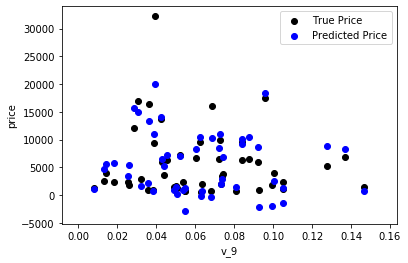

In [6]:
random_viz('v_9')

显然，模型截距数值大，权重分布差异大，绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大。  
观察Price的分布，呈现典型的长尾特征。

It is clear to see the price shows a typical exponential distribution


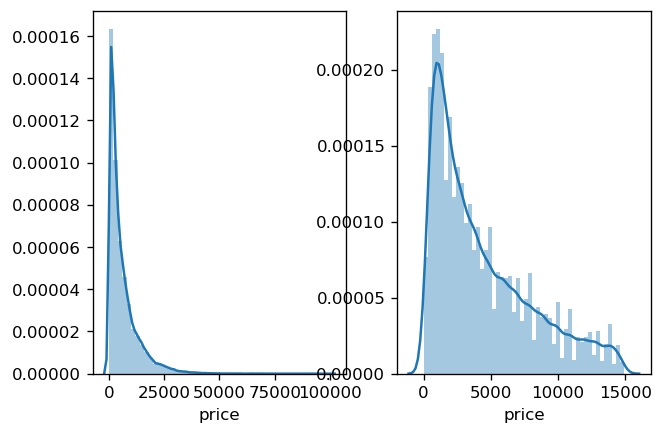

In [7]:
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(dpi=120)
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

### 对数变换

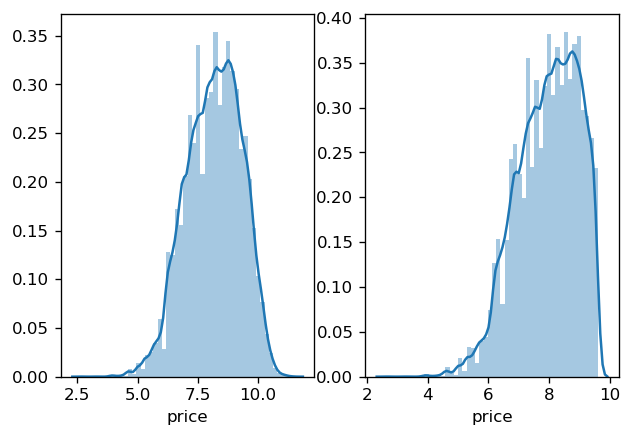

In [8]:
# use log transform
train_y_ln = np.log(train_y + 1)
print('The transformed price seems like normal distribution')
plt.figure(dpi=120)
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [9]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.75074946579568


[('v_9', 8.052409900567861),
 ('v_5', 5.764236596654862),
 ('v_12', 1.6182081236893395),
 ('v_1', 1.4798310582965033),
 ('v_11', 1.1669016563680046),
 ('v_13', 0.9404711296049493),
 ('v_7', 0.7137273083566874),
 ('v_3', 0.6837875771135075),
 ('v_0', 0.008500518010260855),
 ('power_bin', 0.008497969302891808),
 ('gearbox', 0.007922377278336036),
 ('fuelType', 0.006684769706833309),
 ('bodyType', 0.004523520092704863),
 ('power', 0.0007161894205359183),
 ('brand_price_min', 3.334351114747302e-05),
 ('brand_amount', 2.897879704277919e-06),
 ('brand_price_median', 1.2571172873009567e-06),
 ('brand_price_std', 6.659176363428392e-07),
 ('brand_price_max', 6.194956307517389e-07),
 ('brand_price_average', 5.999345965051265e-07),
 ('SaleID', 2.119417003965125e-08),
 ('offerType', 5.419398263484254e-11),
 ('brand_price_sum', -1.5126504215933621e-10),
 ('seller', -1.7469758972765703e-10),
 ('train', -2.304858526258613e-10),
 ('name', -7.015512588883061e-08),
 ('used_time', -4.122479372352162e-06)

Predicted price vs. True price


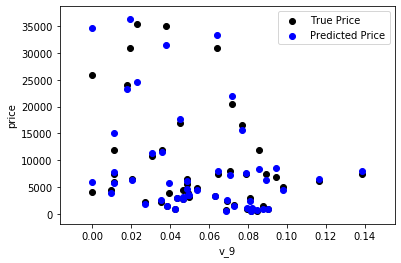

In [10]:
random_viz('v_9', np.exp)

从截距、系数数值，以及散点图可见使用对数变换后线性回归对整体分布的描述较为合适。

## 模型验证

### 五折验证

In [13]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))
print('AVG:', np.mean(scores))

scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))
print('AVG:', np.mean(scores))

scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AVG: 1.3658023920313878
AVG: 0.19325301837047418


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


### 时间序列模拟
由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

In [14]:
import datetime

sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

model = model.fit(train_X, train_y_ln)
mean_absolute_error(val_y_ln, model.predict(val_X))

0.1957766727030092

### 学习率曲线与验证曲线

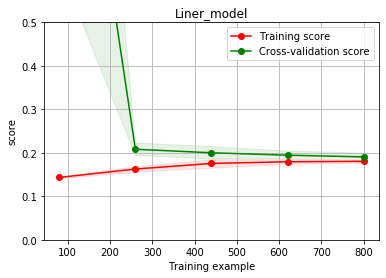

In [15]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    plt.show()

plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

## LR / Ridge / LASSO

In [16]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')
    
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

LinearRegression is finished
Ridge is finished
Lasso is finished


,LinearRegression,Ridge,Lasso
cv1,0.190248,0.194161,0.384174
cv2,0.193295,0.197261,0.383680
cv3,0.192850,0.196666,0.383417
cv4,0.193296,0.197068,0.382575
cv5,0.191939,0.195809,0.379107


intercept:17.271538327973623


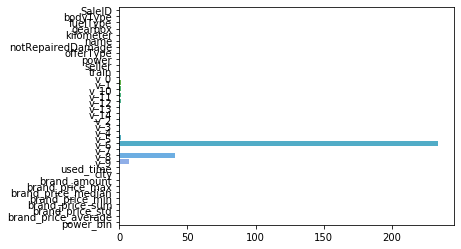

intercept:3.111950488074953


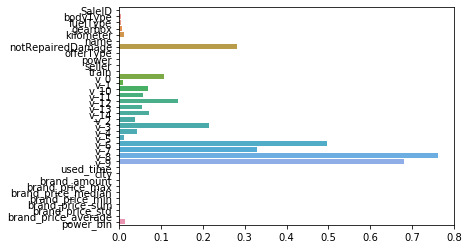

intercept:8.665903327385234


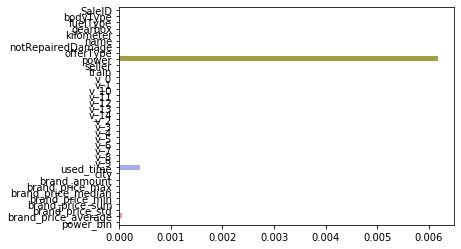

In [18]:
for model in models:
    model = model.fit(train_X, train_y_ln)
    print('intercept:'+ str(model.intercept_))
    sns.barplot(abs(model.coef_), continuous_feature_names)
    plt.show()

正则化效果比直接使用线性回归略差，不过在一定程度上可以提高模型泛化（抗干扰）能力。  
比如L1正则得到的稀疏矩阵中，power和used_time权重较大，与直觉相符。  

## 决策树 / 随机森林 / GDBT / XGBoost ...

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')
    
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190248,0.206640,0.135761,0.167273,556.716096,0.141066,0.142418
cv2,0.193295,0.196062,0.137585,0.171782,108.302303,0.141077,0.144916
cv3,0.192850,0.195383,0.135236,0.171241,1369.361891,0.139594,0.143553
cv4,0.193296,0.194740,0.136422,0.169869,1145.381711,0.138958,0.144573
cv5,0.191939,0.201117,0.136670,0.169550,338.535961,0.142046,0.144205


## 调参
- 贪心算法 https://www.jianshu.com/p/ab89df9759c8
- 网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029
- 贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154

In [20]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

### 贪心
采用贪心策略，每次调整一个参数到最优结果

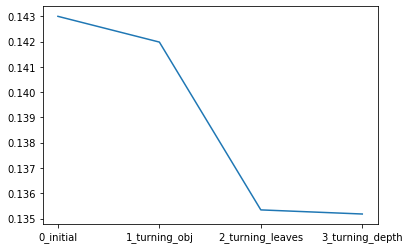

In [21]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score
    
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

### Grid Search
对所有参数进行网格遍历, 即穷举给定范围的所有组合；  
使用验证集调参，进一步 交叉验证；  
缺点：效率低

In [23]:
from sklearn.model_selection import GridSearchCV

parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y_ln)

print(clf.best_params_)

model = LGBMRegressor(**clf.best_params_)
res = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
print(res)

{'max_depth': 10, 'num_leaves': 55, 'objective': 'huber'}
0.13643527735986558


### 贝叶斯
贝叶斯优化问题有四个部分：

- 目标函数：我们想要最小化的内容，在这里，目标函数是机器学习模型使用该组超参数在验证集上的损失。

- 域空间：要搜索的超参数的取值范围

- 优化算法：构造替代函数并选择下一个超参数值进行评估的方法。

- 结果历史记录：来自目标函数评估的存储结果，包括超参数和验证集上的损失。

比随机搜索更加高效

In [25]:
# pip install bayesian-optimization -i https://pypi.douban.com/simple

from bayes_opt import BayesianOptimization

def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8463   |  9.029    |  13.73    |  14.32    |  0.4029   |
|  2        |  0.8613   |  57.21    |  48.38    |  40.56    |  0.6433   |
|  3        |  0.8465   |  90.51    |  33.64    |  14.43    |  0.4486   |
|  4        |  0.8618   |  58.95    |  69.65    |  42.33    |  0.5921   |
|  5        |  0.8129   |  94.25    |  59.32    |  4.49     |  0.4514   |
|  6        |  0.8691   |  97.44    |  2.471    |  99.64    |  0.8686   |
|  7        |  0.8504   |  5.014    |  98.96    |  99.57    |  0.6935   |
|  8        |  0.8687   |  97.84    |  99.38    |  95.77    |  0.7879   |
|  9        |  0.8268   |  5.734    |  97.83    |  6.523    |  0.606    |
|  10       |  0.8686   |  95.48    |  95.79    |  95.01    |  0.4638   |
|  11       |  0.865    |  98.9     |  2.635    |  58.97    |  0.6161   |
|  12       |  0.8129   |  64.15    | 

In [26]:
1 - rf_bo.max['target']

0.13075093599858723